In [1]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import math

In [2]:
y_straight = lambda x : (x * 0)
y1 = lambda x : (50 * x)
y2 = lambda x : (30 * (x * x))
y3 = lambda x : (3 * (x * x)) + (4 * x)
y4 = lambda x : 0 + (20 * x) - (x ** 2) + (3 * (x ** 3))
y5 = lambda x :   (25 * math.log(x + 1)) + (x ** 3)
y6 = lambda x : (4 * x ** 1/3) + (3 * (x ** 1/3))

def build_line(line, sample_rate, random_noise_sd, power_noise_sd):
    total_length = 11
    total_samples = sample_rate * total_length
    x_prime = np.linspace(-10, 1, total_samples, endpoint = True)
    # hoow big of a set do we take for each simulation:
    offset_incrament = (x_prime[1] - x_prime[0]) / 10

    cycles = 60 * total_length # how many sine cycles
    length = np.pi * 2 * cycles
    power_noise = np.sin(np.arange(0, length, length / total_samples))
    power_noise = power_noise * power_noise_sd
    
    out = []
    for j in range(10):
        offset = offset_incrament * j
        x = np.linspace(-10. + offset, 1. + offset, total_samples, endpoint = True)
        y = []
        elbow_i = 0
        for i in x:
            if i < 0:
                y.append(y_straight(i))
                elbow_i += 1
            else:
                y.append(line(i))
        noise = np.random.normal(scale=random_noise_sd, size=total_samples)
        #todo: add 60Hz noise
        out.append((x + 10, np.asarray(y) + noise + power_noise, elbow_i))
    return out

def build_plots(sample_rate=340, random_noise_sd=0.01, power_noise_sd=0.01):
    return {
         "50x": build_line(y1, sample_rate, random_noise_sd, power_noise_sd),
         "30x^2": build_line(y2, sample_rate, random_noise_sd, power_noise_sd),
         "4x + 3x^2": build_line(y3, sample_rate, random_noise_sd, power_noise_sd),
         "20x - x^2 + 3x^3": build_line(y4, sample_rate, random_noise_sd, power_noise_sd),
         "25*log(x + 1) + x^3": build_line(y5, sample_rate, random_noise_sd, power_noise_sd),
         "4x^1/3 + 3x^1/3": build_line(y6, sample_rate, random_noise_sd, power_noise_sd),
        }

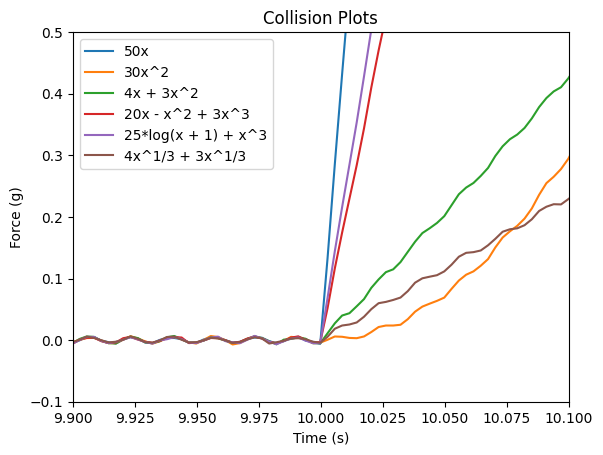

In [3]:
plots = build_plots(random_noise_sd=0.001, power_noise_sd=0.005)
for plot_label in plots:
    plot = plots[plot_label]
    plt.plot(plot[0][0], plot[0][1], label=plot_label)

axes = plt.gca()
axes.set_xlim([9.9, 10.1])
axes.set_ylim([-0.1, 0.5])

plt.xlabel('Time (s)')
plt.ylabel('Force (g)')
plt.legend()
plt.title('Collision Plots')

plt.show()

In [4]:
# guess the the elbow
def dumb_collision_finder(collision_data, elbow_index, plot_name, debug=False):
    return collision_data[elbow_index][0]

In [5]:
def bogo_collision_finder(collision_data, elbow_index, plot_name, debug=False):
    min = collision_data[elbow_index - 1][0]
    max = collision_data[elbow_index][0]
    return np.random.uniform(min, max)

In [6]:
def linear_regression_finder(collision_data, elbow_index, plot_name, debug=False):
    sub_x = collision_data[:, 0][elbow_index:]
    sub_y = collision_data[:, 1][elbow_index:]
    x_stacked = np.vstack([sub_x, np.ones(len(sub_x))]).T
    mxb, residuals, _, _ = np.linalg.lstsq(x_stacked, sub_y, rcond=None)
    # solve for y=0
    m = mxb[0]
    c = mxb[1]
    x = (0 - c) / m
    return x

In [7]:
def estimator_finder(collision_data, elbow_index, plot_name, debug=False):
    pre_elbow_time = collision_data[elbow_index - 1][0]
    pre_elbow_force = collision_data[elbow_index - 1][1]
    elbow_time = collision_data[elbow_index][0]
    elbow_force = collision_data[elbow_index][1]
    end_index = elbow_index + 6
    end_force = collision_data[end_index][1]

    # calculate average force per unit time (assumes axis moves ~constant velocity)
    avg_force = (end_force - pre_elbow_force) / (end_index - elbow_index - 1)
    # what percentage of that average force change is the elbow point away from the point just before it?
    # this has to be clamped to 1. because large force changes are not physically possible
    elbow_force_percent = min(1., abs((elbow_force - pre_elbow_force) / avg_force))
    # time between the two points
    time_d = elbow_time - pre_elbow_time
    time_delta = time_d * elbow_force_percent
    return pre_elbow_time + (time_d - time_delta)

In [8]:
def polyfit_finder(collision_data, elbow_index, plot_name, debug=False):
    # https://stackoverflow.com/questions/16827053/solving-for-x-values-of-polynomial-with-known-y
    from numpy.polynomial import Polynomial as P
    sub_x = collision_data[:, 0][elbow_index:]
    sub_y = collision_data[:, 1][elbow_index:]
    elbow_x = collision_data[elbow_index][0]
    p = P.fit(sub_x, sub_y, 3)
    # debug plot results
    if debug:
        plt.plot(collision_data[:, 0], collision_data[:, 1], label="collision data")
        plt.plot(collision_data[:, 0], p(collision_data[:, 0]), label="polyfit")
        axes = plt.gca()
        #axes.set_xlim([9.0, 11.])
        axes.set_ylim([-5.0, 25.0])
        plt.xlabel('Time (s)')
        plt.ylabel('Force (g)')
        plt.legend()
        plt.title(plot_name)
        plt.show()
    #end debug
    roots = (p - 0.).roots()
    # want a root that is close to but less than elbow_x
    selected_root = None
    root_distance = 999999999.0
    for root in roots:
        if abs(elbow_x - root) < root_distance:
            root_distance = abs(elbow_x - root)
            selected_root = root
    return selected_root

In [9]:
def bspline_finder(collision_data, elbow_index, plot_name, debug=False):
    from scipy.interpolate import splev, splrep
    sub_x = collision_data[:, 0][elbow_index:-1]
    sub_y = collision_data[:, 1][elbow_index:-1]
    spl = splrep(sub_x, sub_y, s=10)
    t0 = collision_data[elbow_index - 1][0]
    t1 = collision_data[elbow_index][0]
    x_extrap = np.linspace(t0, t1, 1000)
    y_extrap = splev(x_extrap, spl)
    y_index = np.argmin(np.abs(y_extrap))
    if debug:
        plt.plot(collision_data[:, 0], collision_data[:, 1], label="collision data")
        spline_x = np.linspace(0., 11., 512)
        spline_y = splev(spline_x, spl)
        plt.plot(spline_x, spline_y, label="bspline")
        axes = plt.gca()
        axes.set_xlim([9.8, 10.2])
        axes.set_ylim([-5.0, 5.0])
        plt.xlabel('Time (s)')
        plt.ylabel('Force (g)')
        plt.legend()
        plt.title(plot_name)
        plt.show()
    return x_extrap[y_index]


In [10]:
collision_algos = {
    "dumb_collision_finder": dumb_collision_finder,
    "bogo_collision_finder": bogo_collision_finder,
    "linear_regression_finder": linear_regression_finder,
    "polyfit_finder": polyfit_finder,
    "bspline_finder": bspline_finder,
    "estimator_finder": estimator_finder,
}

In [11]:
# convert to [[time, force], ...]
def vstack_plot(plot):
    return np.vstack((plot[0], plot[1])).transpose()

In [12]:
def test_collision_finders(sample_rate=340, random_noise_sd=0.01, power_noise_sd=0.01, show_individual_results=False):
    plots = build_plots(sample_rate, random_noise_sd, power_noise_sd)
    scores = {}
    for algo_name in collision_algos:
        algo = collision_algos[algo_name]
        scores[algo_name] = {}
        for plot_name in plots:
            scores[algo_name][plot_name] = 0
            plot_group = plots[plot_name]
            
            for plot in plot_group:
                elbow_index = plot[2]
                collisionTime = algo(vstack_plot(plot), elbow_index, plot_name, debug=False)
                #if (collisionTime > plot[0][elbow_index]):
                #    print("WARNING: collision time too late: %s - %s" % (algo_name, plot_name))
                #if (collisionTime < plot[0][elbow_index - 1]):
                #    print("WARNING: collision time too eary: %s - %s" % (algo_name, plot_name))
                # compare calculated time vs real time:
                scores[algo_name][plot_name] += abs((10. - collisionTime))
            sample_width = plot_group[0][0][1] - plot_group[0][0][0]
            # attempt to make the score a % of the sample width
            scores[algo_name][plot_name] = ((scores[algo_name][plot_name] / len(plot_group))) / sample_width
    
    algo_score = {}
    for algo_name in scores:
        algo_score[algo_name] = np.sum(list(scores[algo_name].values()))
    
    x_labels = np.asarray(list(algo_score.keys()))
    y_values = np.asarray(list(algo_score.values()))
    p = y_values.argsort()[::-1]
    y_pos = np.arange(len(x_labels))
    fig, ax = plt.subplots()
    bars = ax.barh(y_pos, y_values[p], label=x_labels[p])
    ax.bar_label(bars)
    ax.set_yticks(y_pos, labels=x_labels[p])
    plt.title("Overall Results (%s sps, %s noise sd, %s 60Hz sd)" % (sample_rate, random_noise_sd, power_noise_sd))
    plt.show()
    
    if show_individual_results:
        for algo_name in scores:
            algo_results = scores[algo_name]
            x_labels = algo_results.keys()
            y_values = algo_results.values()
            y_pos = np.arange(len(x_labels))
            fig, ax = plt.subplots()
            bars = ax.barh(y_pos, y_values, label=x_labels)
            ax.bar_label(bars)
            ax.set_yticks(y_pos, labels=x_labels)
            plt.xticks(np.arange(0, 11))
            plt.title(algo_name)
            plt.show()

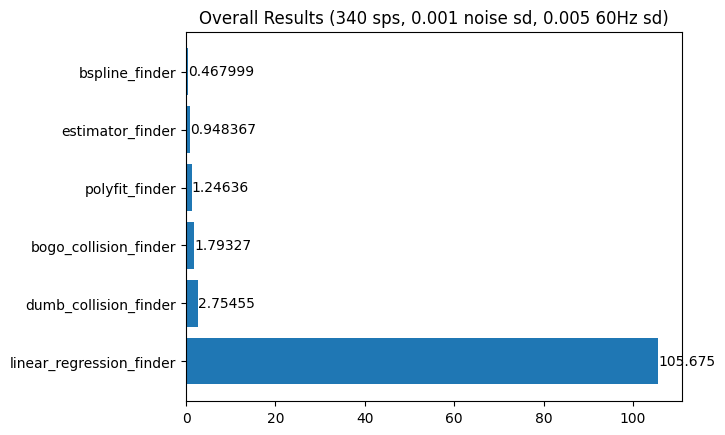

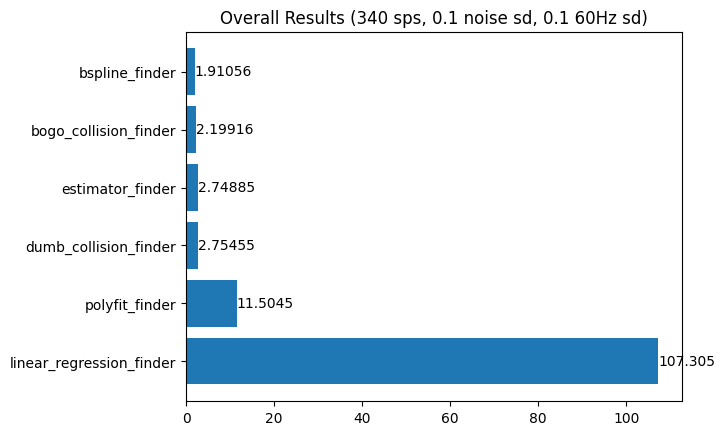

In [13]:
test_collision_finders(sample_rate=340, random_noise_sd=0.001, power_noise_sd=0.005, show_individual_results=False)
test_collision_finders(sample_rate=340, random_noise_sd=0.1, power_noise_sd=0.1, show_individual_results=False)